# MetaMSS

Example created by Wilson Rocha Lacerda Junior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import MetaMSS, FROLS
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

### Meta-Model Structure Selection (MetaMSS) algorithm for building Polynomial NARX models

<AxesSubplot:>

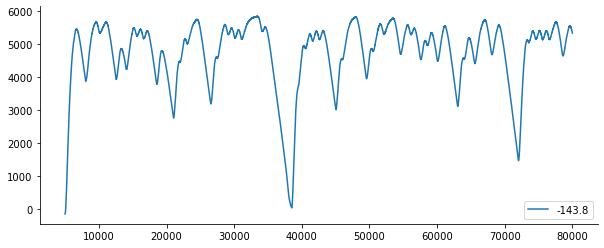

In [2]:
df1 = pd.read_csv('examples/datasets/x_cc.csv')
df2 = pd.read_csv('examples/datasets/y_cc.csv')

df2[5000:80000].plot(figsize=(10, 4))

In [3]:
# we will decimate the data using d=500 in this example
x_train, x_test = np.split(df1.iloc[::500].values, 2)
y_train, y_test = np.split(df2.iloc[::500].values, 2)

In [4]:
basis_function = Polynomial(degree=2)

model = MetaMSS(
    norm=-2,
    xlag=3,
    ylag=3,
    estimator="recursive_least_squares",
    k_agents_percent=10,
    estimate_parameter=True,
    maxiter=30,
    n_agents=10,
    loss_func='metamss_loss',
    basis_function=basis_function
)
model.fit(X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\narmax_base.py:824: RuntimeWarning: overflow encountered in power
  np.power(raw_regressor, model_exponents[j])
c:\Users\wilso\miniconda3\envs\sysidentpy\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:435: RuntimeWarning: overflow encountered in square
  sum_of_squared_residues = np.sum(residues**2)
c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\metrics\_regression.py:215: RuntimeWarning: overflow encountered in square
  numerator = np.sum(np.square((y_predicted - y)))
c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\metrics\_regression.py:216: RuntimeWarning: overflow encountered in square
  denominator = np.sum(np.square((y_predicted - np.mean(y, axis=0))))
c:\Users\wil

0.038462417177693324
        Regressors   Parameters             ERR
0                1  -3.2204E+02  0.00000000E+00
1           y(k-1)   1.3930E+00  0.00000000E+00
2           y(k-2)  -5.4673E-01  0.00000000E+00
3           y(k-3)   6.3161E-02  0.00000000E+00
4          x1(k-1)   2.2296E+01  0.00000000E+00
5          x1(k-2)   1.7402E+01  0.00000000E+00
6          x1(k-3)  -4.2603E+00  0.00000000E+00
7     y(k-3)y(k-1)   2.8055E-05  0.00000000E+00
8    x1(k-1)y(k-1)  -1.5244E-01  0.00000000E+00
9    x1(k-2)y(k-1)  -1.3620E-01  0.00000000E+00
10   x1(k-3)y(k-1)   3.9445E-02  0.00000000E+00
11    y(k-3)y(k-2)  -1.6138E-05  0.00000000E+00
12   x1(k-1)y(k-2)   9.2426E-02  0.00000000E+00
13   x1(k-2)y(k-2)   8.1630E-02  0.00000000E+00
14   x1(k-3)y(k-2)  -2.0450E-02  0.00000000E+00
15   x1(k-1)y(k-3)  -2.3994E-02  0.00000000E+00
16   x1(k-2)y(k-3)  -2.1218E-02  0.00000000E+00
17       x1(k-1)^2   1.1148E+02  0.00000000E+00
18  x1(k-2)x1(k-1)  -3.6302E+00  0.00000000E+00
19       x1(k-2)^2 

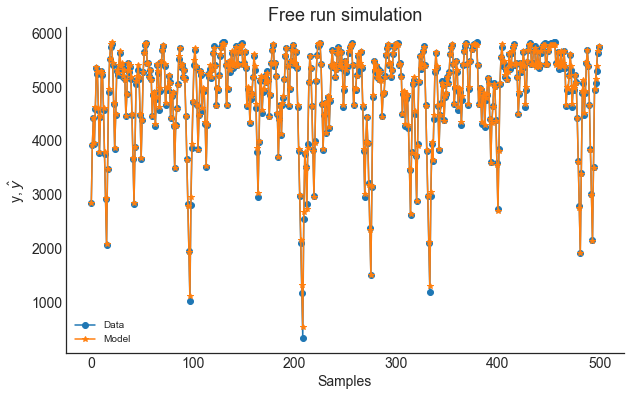

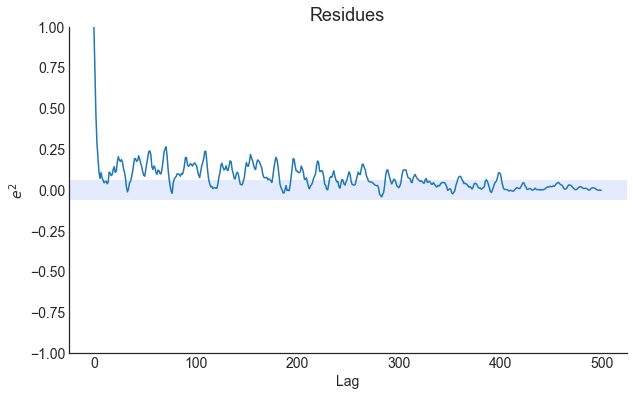

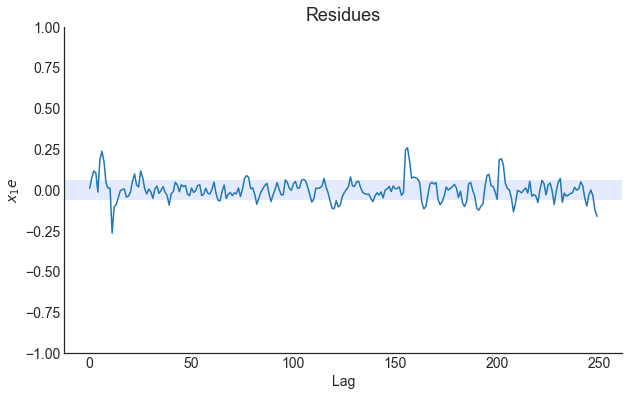

In [6]:
yhat = model.predict(X_test=x_test, y_test=y_test)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

plot_results(y=y_test, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_test, yhat, x_test)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

0.004650987888650369

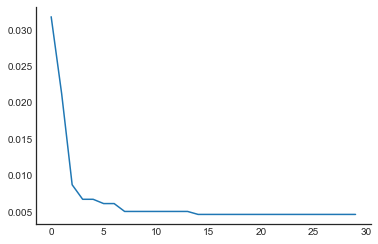

In [7]:
# Ploting the evolution of the agents
plt.plot(model.best_by_iter)
model.best_by_iter[-1]

In [8]:
# You have access to all tested models
# model.tested_models

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sysidentpy.general_estimators import NARX

xlag = ylag = 10

estimators = [
    ('NARX_KNeighborsRegressor', NARX(
        base_estimator=KNeighborsRegressor(),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function)),
    ('NARX_DecisionTreeRegressor', NARX(
        base_estimator=DecisionTreeRegressor(),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function)),
    ('NARX_RandomForestRegressor', NARX(
        base_estimator=RandomForestRegressor(
            n_estimators=200),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function
    )),
    ('NARX_Catboost', NARX(
        base_estimator=CatBoostRegressor(
        iterations=800,
        learning_rate=0.1,
        depth=8),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function,
        fit_params={'verbose': False}
    )),
    ('NARX_ARD', NARX(
        base_estimator=ARDRegression(),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function
    )),
    ('FROLS-Polynomial_NARX', FROLS(
        order_selection=True,
        n_info_values=50,
        extended_least_squares=False,
        ylag=ylag, xlag=xlag,
        info_criteria='bic',
        estimator='recursive_least_squares',
        basis_function=basis_function
        )
    ),
    ('MetaMSS', MetaMSS(norm=-2,
                xlag=xlag,
                ylag=ylag,
                estimator="recursive_least_squares",
                k_agents_percent=10,
                estimate_parameter=True,
                maxiter=20,
                n_agents=15,
                loss_func='metamss_loss',
                basis_function=basis_function)
    )
    
    ]


resultados = {}
for nome_do_modelo, modelo in estimators:
    resultados['%s' % (nome_do_modelo)] = []
    if nome_do_modelo == 'MetaMSS':
        modelo.fit(X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)
        yhat = modelo.predict(X_test=x_test,  y_test=y_test)
    else:
        modelo.fit(X=x_train, y=y_train)
        yhat = modelo.predict(X=x_test,  y=y_test)
    if nome_do_modelo in ['MetaMSS', 'FROLS-Polynomial_NARX']:
        result = root_relative_squared_error(y_test[modelo.max_lag:], yhat[modelo.max_lag:])
    else:
        result = root_relative_squared_error(y_test, yhat)
    resultados['%s' % (nome_do_modelo)].append(result)
    print(nome_do_modelo, '%.3f' % np.mean(result))


NARX_KNeighborsRegressor 1.992
NARX_DecisionTreeRegressor 0.264
NARX_RandomForestRegressor 0.223
NARX_Catboost 0.175
NARX_ARD 0.074
FROLS-Polynomial_NARX 0.047


c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\narmax_base.py:824: RuntimeWarning: overflow encountered in power
  np.power(raw_regressor, model_exponents[j])
c:\Users\wilso\miniconda3\envs\sysidentpy\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:435: RuntimeWarning: overflow encountered in square
  sum_of_squared_residues = np.sum(residues**2)
c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:445: RuntimeWarning: invalid value encountered in sqrt
  se_theta = np.sqrt(var_e)
c:\Users\wilso\miniconda3\envs\sysidentpy\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Us

MetaMSS 0.025


In [10]:
for aux_results, results in sorted(resultados.items(), key=lambda x: np.mean(x[1]), reverse=False):
    print(aux_results, np.mean(results))

MetaMSS 0.025150310881841744
FROLS-Polynomial_NARX 0.04663897799085836
NARX_ARD 0.07413356855178779
NARX_Catboost 0.17463008529882576
NARX_RandomForestRegressor 0.2230679886687048
NARX_DecisionTreeRegressor 0.2643109391717239
NARX_KNeighborsRegressor 1.9917717932592363
